# Train and Data Analysis

- Use Jupyter Notebook for training
- Train on GCP to use Cuda

In [1]:
from Settings import Settings
Settings.learning_rate = 1e-4
Settings.epoch_num = 50
Settings.print_count = 5  # print 5 count for 1 epoch
Settings.batch_size = 10
Settings.drop_out = 0.6

In [2]:
from DataLoader import torch_dataset_loader
from TextCRNN import CRNNModel
from Train import main_train

import json
import matplotlib.pyplot as plt

In [3]:
# Dataloaders
train_loader = torch_dataset_loader(Settings.train_path, Settings.batch_size, True, Settings.kwargs)
validation_loader = torch_dataset_loader(Settings.valid_path, Settings.batch_size, False, Settings.kwargs)
test_loader = torch_dataset_loader(Settings.test_path, Settings.batch_size, False, Settings.kwargs)

## Train Text RCNN Model

In [4]:
txtModel = CRNNModel()
log = main_train(txtModel, train_loader, validation_loader, "train(CRNN).json", "model(CRNN).h5")

Epoch  1 | 347/1737 batches | 181.12ms/ batch | BCE: 0.2513 | Accuracy: 11.73% |
Epoch  1 | 694/1737 batches | 181.05ms/ batch | BCE: 0.2420 | Accuracy: 14.47% |
Epoch  1 | 1041/1737 batches | 181.00ms/ batch | BCE: 0.2321 | Accuracy: 18.14% |
Epoch  1 | 1388/1737 batches | 180.97ms/ batch | BCE: 0.2232 | Accuracy: 22.22% |
Epoch  1 | 1735/1737 batches | 180.94ms/ batch | BCE: 0.2142 | Accuracy: 26.41% |
---------------------------------------------------------------------------------------------------
End of training epoch   1 | time: 314.22s | BCE: 0.2141 | Accuracy: 26.43% |
End of validation epoch   1 | time: 15.84s | BCE: 0.1650 | Accuracy: 48.25% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch  2 | 347/1737 batches | 180.97ms/ batch | BCE: 0.1598 |

KeyboardInterrupt: 

## Model Analysis

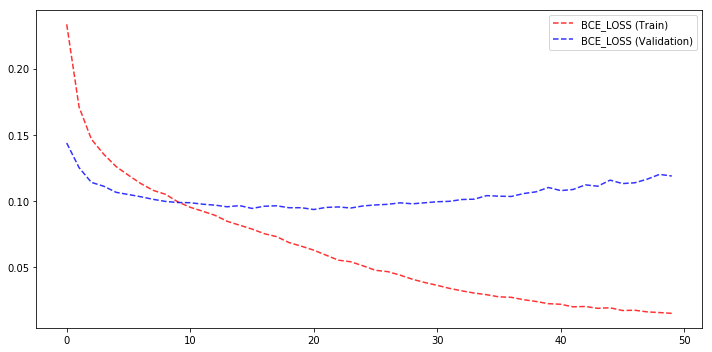

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(log['train_loss'], '--', color=(1,0,0,0.8), label='BCE_LOSS (Train)')
plt.plot(log['valid_loss'], '--', color=(0,0,1,0.8), label='BCE_LOSS (Validation)')
plt.tight_layout()
plt.legend(loc="best")
plt.show()

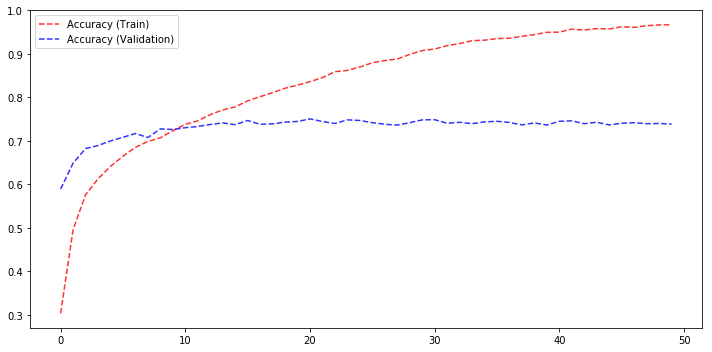

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(log['train_accu'], '--', color=(1,0,0,0.8), label='Accuracy (Train)')
plt.plot(log['valid_accu'], '--', color=(0,0,1,0.8), label='Accuracy (Validation)')
plt.tight_layout()
plt.legend(loc="best")
plt.show()

## Test Model on test set

In [7]:
from Train import validate_test
import torch

In [8]:
txtModel = Model()
txtModel.cuda().load_state_dict(torch.load(Settings.model_save_folder + 'model.h5'))
validate_test(model=txtModel, epoch=0, use_loader=test_loader)

End of validation epoch   0 | time:  0.85s | BCE: 0.0954 | Accuracy: 75.14% |
---------------------------------------------------------------------------------------------------


(0.09539562678220895, 0.7513761467889908)

## Confusion Matrix

In [17]:
from Evaluate import Evaluator
model = Model()
evaluator = Evaluator(model, "model.h5")

In [18]:
evaluator.record_matrix(test_loader, "textCNNconfusion.json")

End of Matrix Record, Save file in ../LogSave/textCNNconfusion.json
---------------------------------------------------------------------------------------------------


In [19]:
import numpy as np
import pandas as pd
import seaborn as sn

In [20]:
matrix = np.zeros((Settings.class_num, Settings.class_num))
with open(Settings.log_save_folder + 'textCNNconfusion.json', 'r') as f:
    tuple_list = json.load(f)

In [21]:
for point in tuple_list:
    i, j = point  # i is predict, j is real, record 100 point for each label
    matrix[i][j] += 1

In [22]:
matrix /= sum(matrix)
matrix = pd.DataFrame(matrix, index = [evaluator.index_to_label.get(str(i+1)) for i in range(Settings.class_num)],
                  columns = [evaluator.index_to_label.get(str(i+1)) for i in range(Settings.class_num)],)

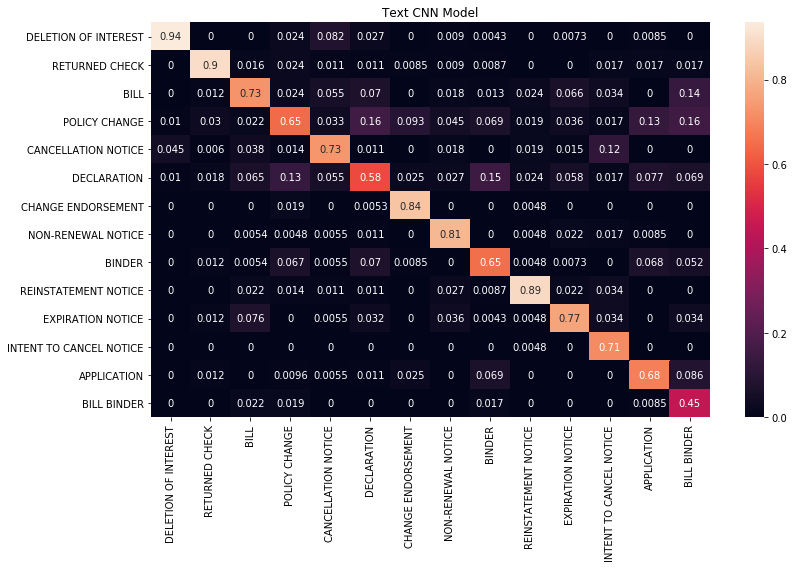

In [23]:
plt.figure(figsize=(12, 8))
plt.title('Text CNN Model')
sn.heatmap(matrix, annot=True,)
plt.tight_layout()
plt.show()

## Conclusion
Current model has 74% accuracy on "chunk test"

# Test model on original set

In [24]:
import csv

csv_file = open(Settings.data_path, "r")
csv_reader = csv.reader(csv_file)

count = 0
right_count = 0
for line in csv_reader:
    label, doc = line
    pred_label, score = evaluator.label_predict(doc)
    count += 1
    if pred_label == label:
        right_count += 1

csv_file.close()
print(count, right_count)

62204 50280


In [25]:
right_count/ count

0.8083081473860202

# Current Model Result

- 80% on full length document
- 75% on chunks